# INM707 Coursework
# DQN with Pytorch


In [227]:
# Ref: Code inspired by INM707 Lab 08, Michael Garcia Oritz, City University of London
# Here, add imports from tutorial that you think are necessary
#import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import random

import matplotlib.pyplot as plt


In [228]:


Action = namedtuple('Action', 'name index delta_i delta_j')
    
up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action

str_to_actions = {}
for action in [up, down, left, right]:
    str_to_actions[action.name] = action


class Town:
    def __init__(self, rows, cols, height=600, width=600, background_color=(0,100,0)) -> None: 
        self.height = height
        self.width = width
        self.rows = rows
        self.cols = cols
        self.block_size = height//self.rows
        self.background_color = background_color
        self.black_color = (0,0,0)
        self.red = (200,0,0)

        #this array will be the representation of our environment:
        self.town = np.zeros((rows, cols), dtype = np.int8)

        self.town[0, :] = 7
        self.town[-1, :] = 7
        self.town[:, 0] = 7
        self.town[:, -1] = 7
        

        #defining the objects in the environment:
                # display help
        #X : Enemy , P: Prison, A: Agent (Prince), R: Restaurant, B: Bar, S: Safe House
        self.dict_map_display={ 0:'.',
                                1:'A',
                                2:'P',
                                3:'R',
                                4:'B',
                                5:'S',
                                6:'X',
                                7:'W'}

        #defining a random coordinate for the starting position of our prince(A)
        # self.prince_start = self.get_empty_cells(1)
        # self.town[self.prince_start[0], self.prince_start[1]] = 1
        self.prince_pos = None

        #defining a random coordinate for the prison where princess is captured
        self.princess_start = self.get_empty_cells(1)
        self.town[self.princess_start[0], self.princess_start[1]] = 2

         # defining rows//5 random coordinates for the Restaurant
        self.restaurant_pos = self.get_empty_cells( int(self.rows//10) )
        self.town[self.restaurant_pos[0], self.restaurant_pos[1]] = 3

        #defining rows//5 random coordinates for the bars
        self.pub_pos = self.get_empty_cells( int(self.rows//10) )
        self.town[self.pub_pos[0], self.pub_pos[1]] = 4

        # defining a random coordinate for the safe house
        self.safe_house_pos = self.get_empty_cells( 1 )
        self.town[self.safe_house_pos[0], self.safe_house_pos[1]] = 5

 
        #defining enemies cells equal to the number of rows:
        self.enemy_pos = self.get_empty_cells( int(self.rows) )
        self.town[self.enemy_pos[0], self.enemy_pos[1]] = 6

        #keeping track of sequence goals:
        self.prison_reached = False
        self.pub_reached = False
        self.restaurant_reached = False
        self.safe_house_reached = False

        self.goal1 = False
        self.goal2 = False
        self.goal3 = False
        self.goal4 = False


        #run time management
        self.time_elapsed = 0
        self.time_limit = self.rows**2



    def get_empty_cells(self, n_cells):
        #this code is taken from INM707 Lab 6-8 for dungeon game by Michael Garcia Oritz:
        empty_cells_coord = np.where( self.town == 0 )
        selected_indices = np.random.choice( np.arange(len(empty_cells_coord[0])), n_cells )
        selected_coordinates = empty_cells_coord[0][selected_indices], empty_cells_coord[1][selected_indices]
        
        if n_cells == 1:
            return np.asarray(selected_coordinates).reshape(2,)
             

        
        return selected_coordinates



    def step(self, action):
        
        # At every timestep, the agent receives a negative reward
        bump = False
        done = False
        reward = -1
        # action is 'up', 'down', 'left', or 'right'
        if action == 'up':
            next_position = (self.prince_pos[0] - 1, self.prince_pos[1] ) 
        if action == 'down':
            next_position = (self.prince_pos[0] + 1, self.prince_pos[1] )
        if action == 'left':
            next_position = (self.prince_pos[0] , self.prince_pos[1] - 1 ) 
        if action == 'right':
            next_position = (self.prince_pos[0] , self.prince_pos[1] + 1) 
        
        # If the agent bumps into a wall, it doesn't move
        if self.town[next_position[0], next_position[1]] == 7:
            bump = True
        else:
            self.prince_pos = next_position

        
        # calculate reward

        next_pos_type = self.town[self.prince_pos[0], self.prince_pos[1]]

        """
        self.dict_map_display={ 0:'.', 1:'A', 2:'P', 3:'R', 4:'B', 5:'S', 6:'X',7:'W'}
        goal1 = reaching prison
        goal2 = reaching restaurant
        goal3 = reaching pub
        goal4 = reaching safe house
        """

        if next_pos_type == 2:
            if not self.prison_reached:
                reward += self.rows**2
                self.goal1 = True
            self.prison_reached = True
          

        if next_pos_type == 3 and not self.goal2:
            if self.goal1:
                reward += 40
                self.goal2 = True
            # else:
            #     reward -= 10
            self.restaurant_reached = True

        if next_pos_type == 4 and not self.goal3:
            if self.goal1:
                reward += 40
                self.goal3 = True
            # else:
            #     reward -= 10
            self.pub_reached = True

        if next_pos_type == 5:
            if self.goal1 and self.goal2 and self.goal3:
                reward += self.rows**2
                #print('Found the final goal!')
                self.goal4 = True
                
            elif self.goal1 and (self.goal2 or self.goal3):
                reward += 80
                #print('Found the final goal!')
                self.goal4 = True
                
            elif self.goal1:
                reward += 40
                #print('Found the final goal!')
                self.goal4 = True
                
            # else:
            #     reward -= 10
            self.safe_house_reached = True

        if next_pos_type == 6:
            reward -= 20
            
        if bump:
            reward -= 5

        # calculate observations
        observations = self.calculate_observations(reset=False)
        
        # update time
        self.time_elapsed += 1
        
        # verify termination condition
        if self.time_elapsed == self.time_limit:
            #print('Time limit!')
            done = True
            
        if self.goal4:
            done =True

        return observations, reward, done


    def displayMatrix(self):
        
        envir_with_agent = self.town.copy()
        envir_with_agent[self.prince_pos[0], self.prince_pos[1]] = 1
        
        full_repr = ""

        for r in range(self.rows):
            
            line = ""
            
            for c in range(self.cols):

                string_repr = self.dict_map_display[ envir_with_agent[r,c] ]
                
                line += "{0:2}".format(string_repr)

            full_repr += line + "\n"

        print(full_repr)

    def calculate_observations(self, channelise = False, reset = False):
        if reset:
            self.prince_pos = np.asarray(self.get_empty_cells(1))
            self.time_elapsed = 0
            self.prison_reached = False
            self.bar_reached = False
            self.restaurant_reached = False
            self.safe_house_reached = False
            self.goal1 = False
            self.goal2 = False
            self.goal3 = False
            self.goal4 = False


        relative_coordinates2 = self.safe_house_pos - self.prince_pos
        relative_coordinates1 = self.princess_start - self.prince_pos
        
        #placing prince to his position:
        self.town[self.prince_pos[0], self.prince_pos[1]] = 1

                
        #Pad with zeros
        town_padded = np.ones( (self.rows + 4, self.cols + 4), dtype = np.int8)*7
        #print(town_padded)
        town_padded[2:self.rows+2, 2:self.cols+2] = self.town[:,:]
        #print(town_padded)
        surroundings = town_padded[ self.prince_pos[0] + 2 -3: self.prince_pos[0]+ 2 +4,
                                     self.prince_pos[1]+ 2 -3: self.prince_pos[1]+ 2 +4]
        
        #print(self.prince_pos)
        #print(surroundings)
        if channelise:
            surroundings = self.getStateTensorChannels(surroundings)
        obs = {'relative_coordinates1':relative_coordinates1,
               'relative_coordinates2':relative_coordinates2,
               'surroundings': surroundings}
        
        return obs

    def getStateTensorChannels(self, surroundings):
        #we have 6 different objects in our grid : prince, prsion, bar, restaurant, enemy, castle hence we need a channel for each object hence 6 channels
        states = np.zeros((6,5,5))
        # obs = self.calculate_observations()   
        # surroundings = obs['surroundings']
        # #print(surroundings)

        for i in range(len(surroundings)):
            for j in range(len(surroundings[i])):
                if surroundings[i][j] == 1:
                    states[0,i,j] = 1
                if surroundings[i][j] == 2:
                    states[1,i,j] = 1
                if surroundings[i][j] == 3:
                    states[2,i,j] = 1
                if surroundings[i][j] == 4:
                    states[3,i,j] = 1
                if surroundings[i][j] == 5:
                    states[4,i,j] = 1
                if surroundings[i][j] == 6:
                    states[5,i,j] = 1          
        
#         states[1,self.princess_start[0],self.princess_start[1]] = 1
#         states[2,self.safe_house_pos[0],self.safe_house_pos[1]] = 1
#         states[3,self.pub_pos[0],self.pub_pos[1]] = 1
#         states[4,self.restaurant_pos[0],self.restaurant_pos[1]] = 1
#         states[5,self.enemy_pos[0],self.enemy_pos[1]] = 1
        
    

      # for (r,c) in self.enemy_pos:
      #   states[5,r,c] = 1

        return states

    def getStateTensorCNN(self,reset=False):
        #we have 6 different objects in our grid : prince, prsion, bar, restaurant, enemy, castle hence we need a channel for each object hence 6 channels
        states = torch.zeros(self.rows, self.cols)
        if reset:
            self.prince_pos = np.asarray(self.get_empty_cells(1))
            self.time_elapsed = 0
            self.prison_reached = False
            self.bar_reached = False
            self.restaurant_reached = False
            self.safe_house_reached = False
            self.goal1 = False
            self.goal2 = False
            self.goal3 = False
            self.goal4 = False
        """
        self.dict_map_display={ 0:'.', 1:'A', 2:'P', 3:'R', 4:'B', 5:'S', 6:'X'}
        """
        #in this second method, we will assign a code for each object in the state:
        # 1: Prince Pos, 2:Prison/Princess Start, 3:Restauarnt , 4: Pub, 5: Enemy, 6: Safe House
        states[self.prince_pos[0],self.prince_pos[1]] = 1

        states[self.princess_start[0],self.princess_start[1]] = 2
        states[self.restaurant_pos[0],self.restaurant_pos[1]] = 3
        states[self.pub_pos[0],self.pub_pos[1]] = 4
        states[self.safe_house_pos[0],self.safe_house_pos[1]] = 5
        states[self.enemy_pos[0], self.enemy_pos[1]] = 6

        #print(states)
        return states.unsqueeze(0)



# Replay Buffer for Experience replay

In [229]:
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [230]:
def convert_state(state,N,normalize=False,CNN = False):
    if CNN:
        state_tensor = torch.tensor(state, device=device, dtype = torch.float32).unsqueeze(0)
        return state_tensor
        
    else:
        c1 = state['relative_coordinates1'].flatten()
        c2 = state['relative_coordinates2'].flatten()
        o = state['surroundings'].flatten()


        if normalize: 
            c1 = c1 / N
            c2 = c2 / N
            o = o / 4

        state_tensor = np.concatenate( [c1,c2,o] )
        state_tensor = torch.tensor(state_tensor, device=device, dtype = torch.float32).unsqueeze(0)
        return state_tensor
        
    
    #print(state_tensor.size())
    
    

class ReplayMemory:

    # TODO: set up normalization and reward scaling
    # You can also improve it based ion pytorch tutorial (use dequeue)

    def __init__(self, capacity, normalize, rows, USE_CNN):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.reward_scaling = False
        self.N = rows
        self.normalize = normalize
        self.USE_CNN = USE_CNN


    def push(self, state, action, next_state, reward):

        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        state_tensor = convert_state(state,self.N,self.normalize, self.USE_CNN)
        #state_tensor = state
        
        if next_state is None:
            state_tensor_next = None            
        else:
            state_tensor_next = convert_state(next_state,self.N,self.normalize, self.USE_CNN)
            #state_tensor_next = next_state

            
        action_tensor = torch.tensor([action], device=device).unsqueeze(0)

        if self.reward_scaling:
            # Scale reward to [0, 1] range
            reward = torch.tensor([reward / self.N**2], device=device).unsqueeze(0)
        else:
            reward = torch.tensor([reward], device=device).unsqueeze(0)

        self.memory[self.position] = Transition(state_tensor, action_tensor, state_tensor_next, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #print('Len of memory:', len(self.memory))
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Q-network

In [231]:
from torch.nn.modules.linear import Linear
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN_CNN(nn.Module):

    def __init__(self, input_dim, size_hidden, output_size):
        
        super().__init__()
        #print(input_dim)
        self.BATCH_SIZE = BATCH_SIZE
        
        # Declare the different layers
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=1, stride=1),
            nn.ReLU()
            )
      
        self.fc_layer_inputs = self.cnn_out_dim(input_dim)

        self.fc = nn.Sequential(
            nn.Linear(self.fc_layer_inputs, size_hidden),
            nn.ReLU(),
            nn.Linear(size_hidden, output_size)
        )

             
    def forward(self, x):
        #print('Shape of input : ',x.size())
        # Declare how the data flows from input x to output.

        features = self.cnn(x)
  
        #print(features.size())
        #features = features.flatten().unsqueeze(0)
        features = features.view(-1, self.fc_layer_inputs)
        #print(features.size())
        output = self.fc(features)


        #features = F.relu(features)
        #x = self.fc3(x)
        #x = F.relu(x)

        
        return output

    def cnn_out_dim(self, input_dim):
        #print(torch.zeros(1, *input_dim).size())
        return self.cnn(torch.zeros(1, *input_dim)
            ).flatten().shape[0]
    

class DQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size):
        
        super().__init__()
        
        # Declare the different layers
        self.fc = nn.Sequential(
            nn.Linear(input_size, size_hidden),
            nn.ReLU(),
            nn.Linear(size_hidden, size_hidden//2),
            nn.ReLU(),
            nn.Linear(size_hidden//2, size_hidden//4),
            nn.ReLU(),
            nn.Linear(size_hidden//4, output_size)
            # nn.ReLU(),
            # nn.Linear(size_hidden, output_size)
         )

        
        
    def forward(self, x):
        #print(x,x.size())
        # Declare how the data flows from input x to output.
        q_vals = self.fc(x)
      
        return q_vals

class DuelingDQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size):
        
        super().__init__()
        
        # Declare the different layers
        self.fc = nn.Sequential(
            nn.Linear(input_size, size_hidden),
            nn.ReLU(),
            nn.Linear(input_size, size_hidden),
            nn.ReLU()
        )

        self.fc_val = nn.Sequential(
            nn.Linear(size_hidden, size_hidden),
            nn.ReLU(),
            nn.Linear(size_hidden,1)
        )

        self.fc_adv = nn.Sequential(
            nn.Linear(size_hidden, size_hidden),
            nn.ReLU(),
            nn.Linear(size_hidden, output_size)
        )

        
        
    def forward(self, x):
        #print(x,x.size())
        # Declare how the data flows from input x to output.
        x = self.fc(x)

        x_val = self.fc_val(x)
        x_adv = self.fc_adv(x)

        q_vals = x_val + (x_adv - x_adv.mean())
        
        return q_vals

# Implementation

In [232]:
myTown = Town(20,20)
states = myTown.calculate_observations(channelise = False,reset=True)
#states = myTown.getStateTensorChannels(reset=True)
print(states)
myTown.displayMatrix()

{'relative_coordinates1': array([12,  5]), 'relative_coordinates2': array([ 2, -5]), 'surroundings': array([[7, 7, 7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7, 7, 7],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int8)}
W W W W W W W W W W W W W W W W W W W W 
W . . . . . . . . A . . . . . . . . X W 
W . . . . . . . . . . . . . . . . . . W 
W . . . S . . . . B . . . . . X . . . W 
W . . . . . . . . . . . . . . . . . . W 
W . . . . . . . . . . . . . X . . . . W 
W . . . . . . . . . X . . X . . . . . W 
W . X . . . . . . . . . . . . . . . . W 
W . . . . . . . . . . . . . . . . . . W 
W . . . . X . . . . . . . . . . . . . W 
W . R . . . . . . . . . . . . . . X X W 
W . . . . . . . . X . . . . . . . . . W 
W . . . . . . . . . . X . . . . . . . W 
W . . . . . . . X . . . . . P . . . . W 
W . . . . . . . . . . . . X . . . . . W 
W . . . X . . . X . . . . . . X . . . W 
W . . . . . . . . .

In [233]:
#OBS_SIZE_CNN = states.size()
OBS_SIZE = 7*7 + 2 + 2
#OBS_SIZE_CHANNEL = 5*5*6 + 2+2
#print(OBS_SIZE_CNN)
HIDDEN_SIZE = 256
ACTION_SIZE = 4
BATCH_SIZE = 256
GAMMA = 0.99
USE_CNN = False



# # #USING vanilla DQN network
# Q_network = DQN_CNN( OBS_SIZE_CNN, HIDDEN_SIZE, ACTION_SIZE).to(device)
# Q_target = DQN_CNN( OBS_SIZE_CNN, HIDDEN_SIZE, ACTION_SIZE).to(device)
# Q_target.load_state_dict(Q_network.state_dict())


# #USING vanilla DQN network
# Q_network = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
# Q_target = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
# Q_target.load_state_dict(Q_network.state_dict())


USING Dueling DQN network:
Q_network = DuelingDQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target = DuelingDQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target.load_state_dict(Q_network.state_dict())


Q_target.eval()
TARGET_UPDATE = 200
normalize = True
optimizer = optim.Adam(Q_network.parameters(), lr=0.001)
memory = ReplayMemory(30000, normalize, 20, USE_CNN)


# Epsilon-greedy policy



In [234]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
                
    def __call__(self, state):
                
        is_greedy = random.random() > self.epsilon
        
        if is_greedy :
            # we select greedy action
            with torch.no_grad():
                Q_network.eval()
                index_action = Q_network(state).max(1)[1].view(1,1).item()
                Q_network.train()
        else:
            # we sample a random action
            index_action = random.randint(0,3)
        
        return index_action
                
    def update_epsilon(self):
        
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start
        
        


# Training loop

In [235]:

policy = E_Greedy_Policy(0.99, decay=0.997, min_epsilon=0.001)

def optimize_model(double_dqn=False):
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # print(batch.state)
    # print(batch.next_state)
    # for el in batch.next_state:
    #   print(el)

    # for el in batch.state:
    #   print(el.size())

    # Compute a mask of non-final states and concatenate the batch elements


    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    #print('size of non final mask,', non_final_mask.size())
    
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)


    # Compute Q values using policy net
    #print('state_batch', state_batch.size())
    #print('action batch', action_batch.size())
    
    Q_values = Q_network(state_batch).gather(1, action_batch)
    #check if using double DQN:
    if double_dqn:
         # Compute next actions using policy net and Double DQN
        next_actions = Q_network(non_final_next_states).max(1)[1].unsqueeze(0)

        # Compute next Q values using target net and Double DQN
        next_Q_values = torch.zeros(BATCH_SIZE, device=device)
        next_Q_values[non_final_mask] = Q_target(non_final_next_states).gather(1, next_actions).squeeze(1)

        # Compute targets
        target_Q_values = reward_batch + GAMMA * next_Q_values.unsqueeze(1)
        #target_Q_values = reward_batch + GAMMA * next_Q_values * non_final_mask.unsqueeze(1)
        #target_Q_values = target_Q_values.unsqueeze(1)
    
#         _, actions = Q_network(non_final_next_states).max(dim=1, keepdim=True)

#         # Compute next Q values using Q_targets
#         #print('actions shape :', actions.size())
#         #print('input : ', non_final_next_states.size())
#         next_Q_values = torch.zeros(BATCH_SIZE, device=device)
#         #with torch.no_grad():
#         next_Q_values[non_final_mask] = Q_target(non_final_next_states).gather(dim=1, index=actions).squeeze()

#         # Compute targets
#         target_Q_values = reward_batch + GAMMA * next_Q_values.unsqueeze(1)
#         #target_Q_values = (next_Q_values * GAMMA) + reward_batch


      #target_Q_values = double_dqn_q_learing(state_batch, action_batch, reward_batch, done_batch)

    else:
      # Compute next Q values using Q_targets

      next_Q_values = torch.zeros(BATCH_SIZE, device=device)
      next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach()
      target_Q_values = reward_batch + GAMMA * next_Q_values.unsqueeze(1)
     
    
    # Compute MSE Loss
    #print(Q_values.size(), target_Q_values.size())
    loss = F.mse_loss(Q_values, target_Q_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Trick: gradient clipping
    for param in Q_network.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()
    
    return loss

In [225]:
num_episodes = 2000

#Environment:
NUM_ROWS = 20
NUM_COLS = 20


policy.reset()

rewards_history = []
losses_history = []
# Warmup phase!
memory_filled = False

while not memory_filled:
    
    myTown = Town(NUM_ROWS,NUM_COLS)
    #state = myTown.getStateTensorChannels(reset=True)
    state = myTown.calculate_observations(reset=True)
    done = False
        
    while not done:
        
        # Get action and act in the world
        state_tensor = convert_state(state,NUM_ROWS)
        #print(state_tensor.size())
        action = policy(state_tensor)
        #print(action)
        action_name = index_to_actions[action].name 
        #print(action, action_name)
        next_state, reward, done = myTown.step(action_name)
                
        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        #print(state,action)
        memory.push(state, action, next_state, float(reward))
        
        state = next_state


    memory_filled = memory.capacity == len(memory)

print('Done with the warmup')
    
for i_episode in range(num_episodes):
    
    # New dungeon at every run?
    
    myTown = Town(NUM_ROWS,NUM_COLS)
    #state = myTown.getStateTensorChannels(reset=True)
    state = myTown.calculate_observations(reset=True)
    done = False
    
    total_reward = 0
    
    while not done:
        
        # Get action and act in the world
        state_tensor = convert_state(state,NUM_ROWS)
        
        action = policy(state_tensor)
        action_name = index_to_actions[action].name 
        next_state, reward, done = myTown.step(action_name)
        
        total_reward += float(reward)
        
        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward))

        # Move to the next state
        state = next_state
        #print(state_tensor)
        # Perform one step of the optimization
        started_training = True
        l = optimize_model(double_dqn=True)

    policy.update_epsilon()
    rewards_history.append( float(total_reward) )

    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        # We copy the Q-net state into Q-target state
        Q_target.load_state_dict(Q_network.state_dict())
    
    if (i_episode) % 10 == 0:
        
        print('Episode ', i_episode, ': ', 'reward :',  total_reward, 'eps: ', 
              policy.epsilon, ' loss:', l.detach().cpu())   
        print( sum(rewards_history[-10:])/10)    

print('Complete')


Done with the warmup
Episode  0 :  reward : -525.0 eps:  0.98703  loss: tensor(1.2135)
-52.5
Episode  10 :  reward : -525.0 eps:  0.9578156659018894  loss: tensor(34.8886)
-592.4
Episode  20 :  reward : -725.0 eps:  0.9294660241807036  loss: tensor(39.3826)
-595.5
Episode  30 :  reward : -620.0 eps:  0.9019554814785994  loss: tensor(0.3926)
-540.4
Episode  40 :  reward : -710.0 eps:  0.8752592019556485  loss: tensor(1.0354)
-569.1
Episode  50 :  reward : -705.0 eps:  0.8493530848686524  loss: tensor(2.6671)
-560.1
Episode  60 :  reward : -500.0 eps:  0.8242137428135844  loss: tensor(2.6711)
-513.6
Episode  70 :  reward : -745.0 eps:  0.79981848061202  loss: tensor(0.4987)
-641.5
Episode  80 :  reward : -555.0 eps:  0.776145274822487  loss: tensor(0.5254)
-620.5
Episode  90 :  reward : -530.0 eps:  0.7531727538582468  loss: tensor(0.2303)
-577.0
Episode  100 :  reward : -395.0 eps:  0.7308801786935519  loss: tensor(4.8696)
-569.0
Episode  110 :  reward : -346.0 eps:  0.7092474241409645 

In [30]:
import pandas as pd

## Vanilla DQN Experiments

Text(0.5, 1.0, 'Vanilla DQN')

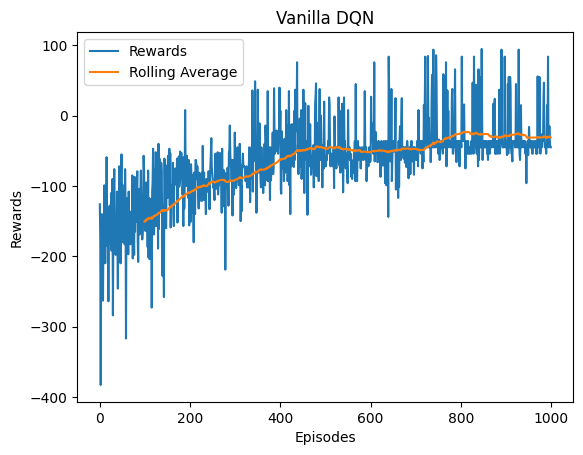

In [ ]:


vanillaDQN_rewards = pd.Series(rewards_history)
vanillaDQN_losses = losses_history

plt.plot(vanillaDQN_rewards, label='Rewards')
plt.plot(vanillaDQN_rewards.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.title('Vanilla DQN')

Text(0.5, 1.0, 'Vanilla DQN')

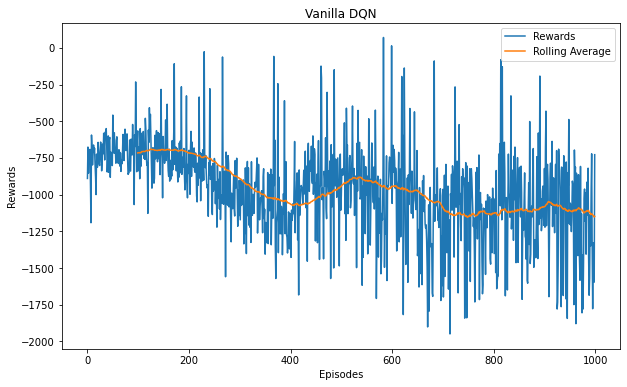

In [31]:
"""Vanilla DQN with CNN"""

vanillaDQN_rewards = pd.Series(rewards_history)
vanillaDQN_losses = losses_history
plt.figure(figsize=(10,6))
plt.plot(vanillaDQN_rewards, label='Rewards')
plt.plot(vanillaDQN_rewards.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.title('Vanilla DQN')

Text(0.5, 1.0, 'Vanilla DQN')

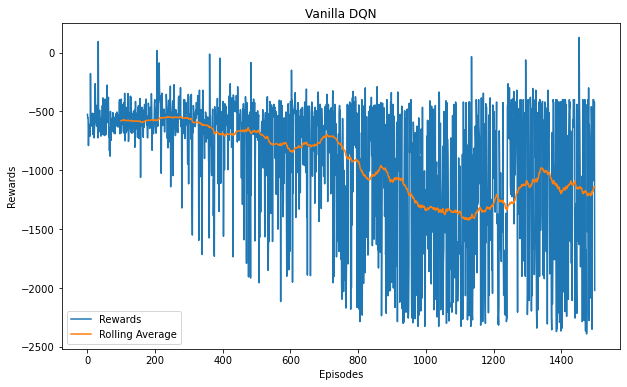

In [226]:
"""Vanilla DQN with CNN"""

vanillaDQN_rewards = pd.Series(rewards_history)
vanillaDQN_losses = losses_history
plt.figure(figsize=(10,6))
plt.plot(vanillaDQN_rewards, label='Rewards')
plt.plot(vanillaDQN_rewards.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.title('Vanilla DQN')

Text(0.5, 1.0, 'Vanilla DQN')

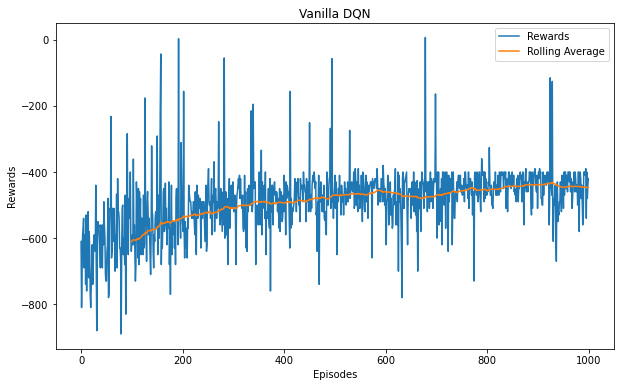

In [80]:


vanillaDQN_rewards = pd.Series(rewards_history)
vanillaDQN_losses = losses_history
plt.figure(figsize=(10,6))
plt.plot(vanillaDQN_rewards, label='Rewards')
plt.plot(vanillaDQN_rewards.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.title('Vanilla DQN')

/tmp/ipykernel_184620/3617411105.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vanillaDQN_losses = pd.Series(vanillaDQN_losses)


Text(0.5, 1.0, 'Vanilla DQN')

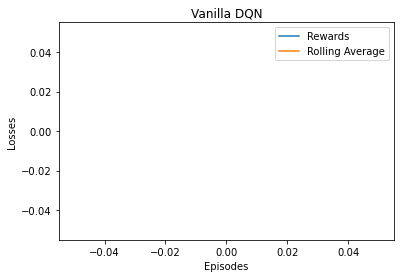

In [17]:
vanillaDQN_losses = pd.Series(vanillaDQN_losses)

plt.plot(vanillaDQN_losses, label='Rewards')
plt.plot(vanillaDQN_losses.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Losses')
plt.legend()
plt.title('Vanilla DQN')

Text(0.5, 1.0, 'Vanilla DQN')

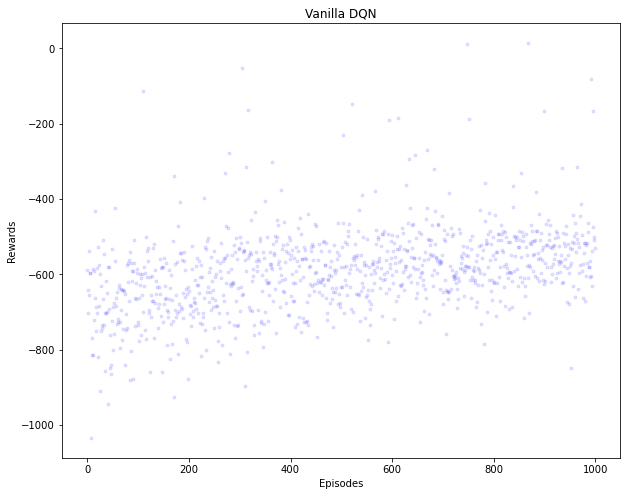

In [121]:
plt.figure(figsize=(10,8))  
plt.plot(vanillaDQN_rewards, 'b.', alpha=.1)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Vanilla DQN')

## Double DQN

Text(0.5, 1.0, 'Double DQN')

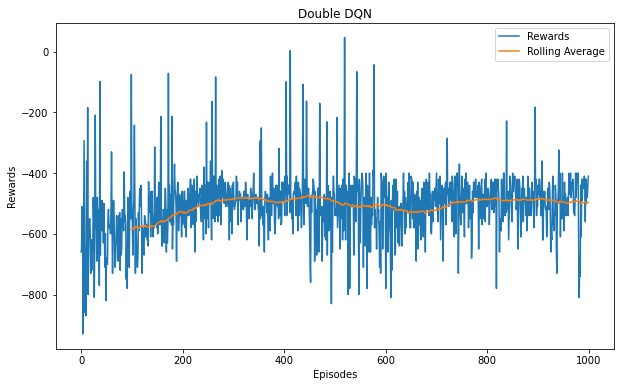

In [84]:


doubleDQN_rewards = pd.Series(rewards_history)
doubleDQN_losses = losses_history
plt.figure(figsize=(10,6))
plt.plot(doubleDQN_rewards, label='Rewards')
plt.plot(doubleDQN_rewards.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.title('Double DQN')

Text(0.5, 1.0, 'Double DQN')

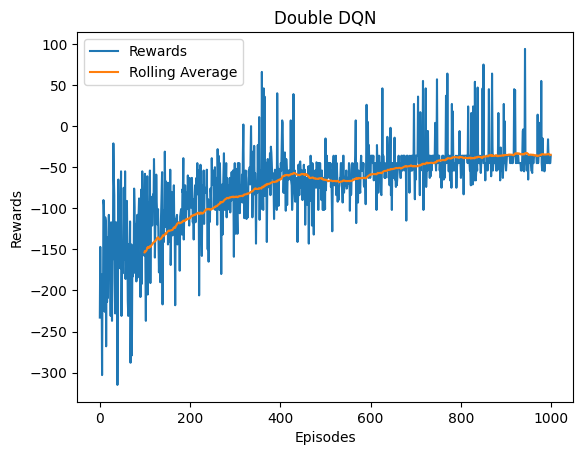

In [ ]:


doubleDQN_rewards = pd.Series(rewards_history)
doubleDQN_losses = losses_history

plt.plot(doubleDQN_rewards, label='Rewards')
plt.plot(doubleDQN_rewards.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.title('Double DQN')

Text(0.5, 1.0, 'Double DQN')

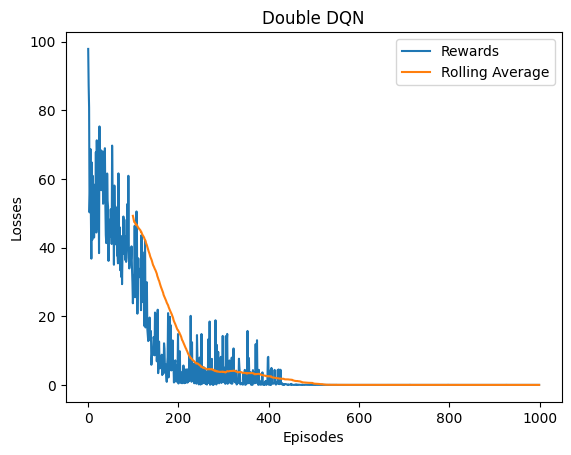

In [ ]:
doubleDQN_losses = pd.Series(doubleDQN_losses)

plt.plot(doubleDQN_losses, label='Rewards')
plt.plot(doubleDQN_losses.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Losses')
plt.legend()
plt.title('Double DQN')

Text(0.5, 1.0, 'Double DQN')

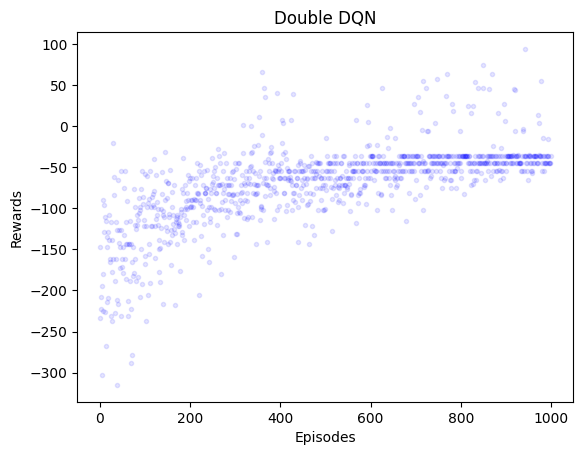

In [ ]:
  plt.plot(doubleDQN_rewards, 'b.', alpha=.1)
  plt.xlabel('Episodes')
  plt.ylabel('Rewards')
  plt.title('Double DQN')

## Dueling DQN

Text(0.5, 1.0, 'Double DQN with Dueling DQN Network')

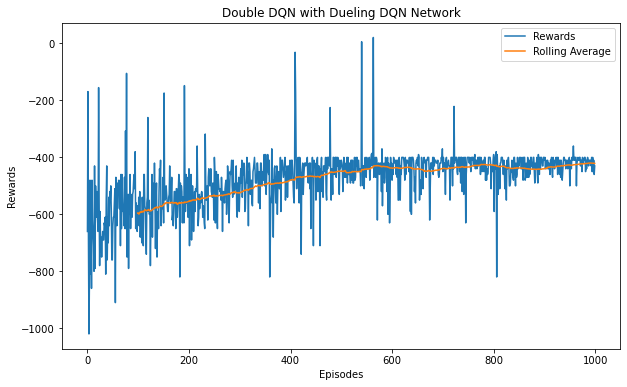

In [90]:
doubleDuelDQN_rewards = pd.Series(rewards_history)
doubleDuelDQN_losses = losses_history
plt.figure(figsize=(10,6))
plt.plot(doubleDuelDQN_rewards, label='Rewards')
plt.plot(doubleDuelDQN_rewards.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.title('Double DQN with Dueling DQN Network')

Text(0.5, 1.0, 'Double DQN with Dueling DQN Network')

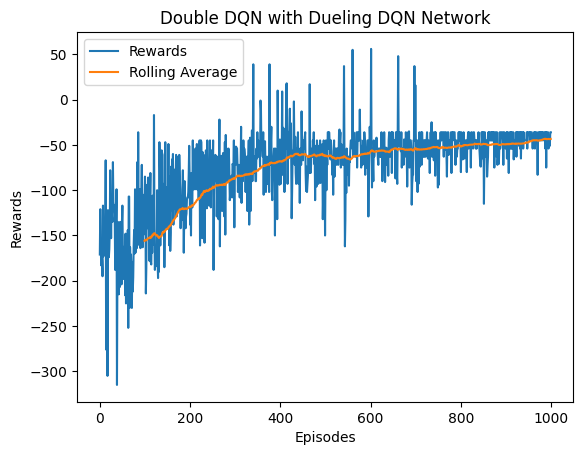

In [ ]:
doubleDuelDQN_rewards = pd.Series(rewards_history)
doubleDuelDQN_losses = losses_history

plt.plot(doubleDuelDQN_rewards, label='Rewards')
plt.plot(doubleDuelDQN_rewards.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.title('Double DQN with Dueling DQN Network')

Text(0.5, 1.0, 'Dueling DQN')

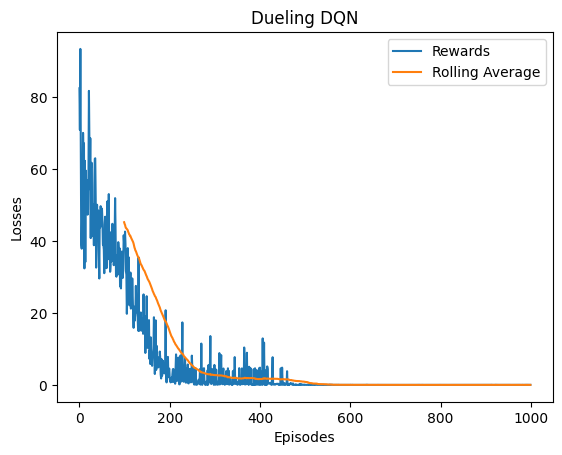

In [ ]:
doubleDuelDQN_losses = pd.Series(doubleDuelDQN_losses)

plt.plot(doubleDuelDQN_losses, label='Rewards')
plt.plot(doubleDuelDQN_losses.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Losses')
plt.legend()
plt.title('Dueling DQN')

Text(0.5, 1.0, 'Loss Convergence of Three Models')

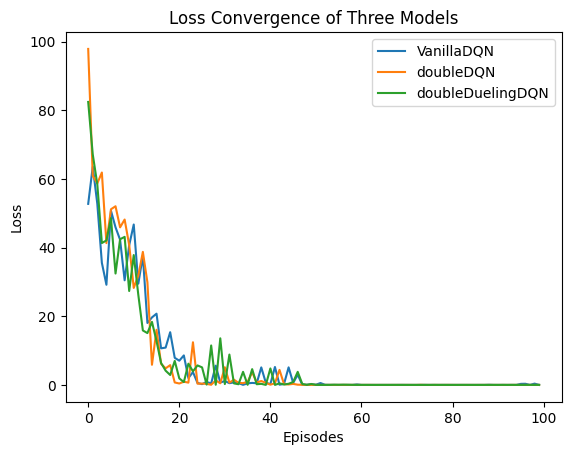

In [ ]:
plt.plot(vanillaDQN_losses[::10], label='VanillaDQN')
plt.plot(doubleDQN_losses[::10], label='doubleDQN')
plt.plot(doubleDuelDQN_losses[::10], label='doubleDuelingDQN')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Convergence of Three Models')

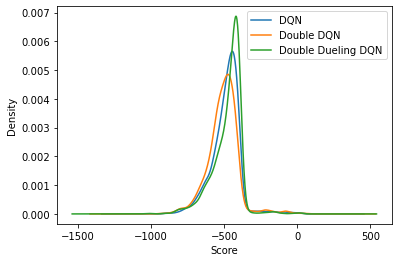

In [91]:
fig, ax = plt.subplots(1,1)

_ = vanillaDQN_rewards.plot(kind="kde", ax=ax, label="DQN")
_ = doubleDQN_rewards.plot(kind="kde", ax=ax, label="Double DQN")
_ = doubleDuelDQN_rewards.plot(kind="kde", ax=ax, label="Double Dueling DQN")
_ = ax.set_xlabel("Score")
_ = ax.legend()

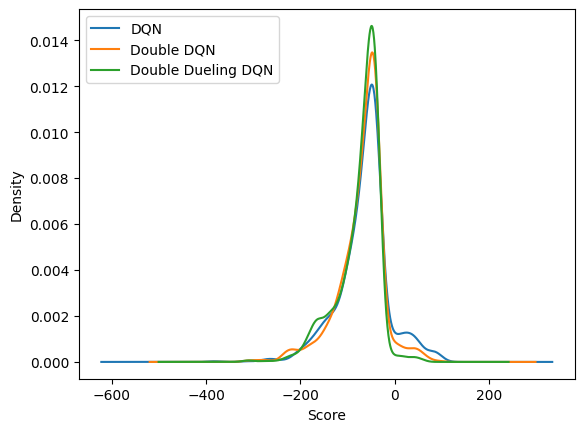

In [ ]:
fig, ax = plt.subplots(1,1)
_ = vanillaDQN_rewards.plot(kind="kde", ax=ax, label="DQN")
_ = doubleDQN_rewards.plot(kind="kde", ax=ax, label="Double DQN")
_ = doubleDuelDQN_rewards.plot(kind="kde", ax=ax, label="Double Dueling DQN")
_ = ax.set_xlabel("Score")
_ = ax.legend()

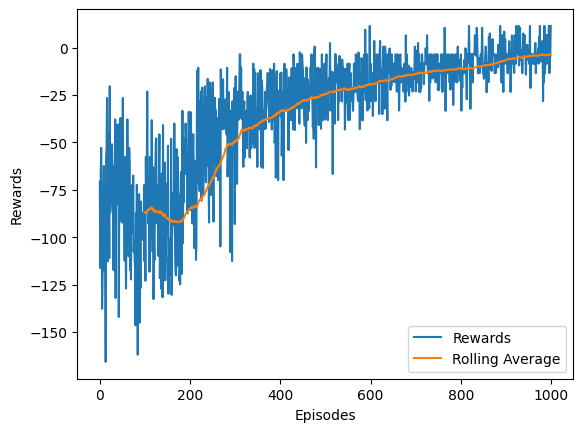

In [ ]:
#fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)



Text(0.5, 1.0, 'Dueling Double DQN')

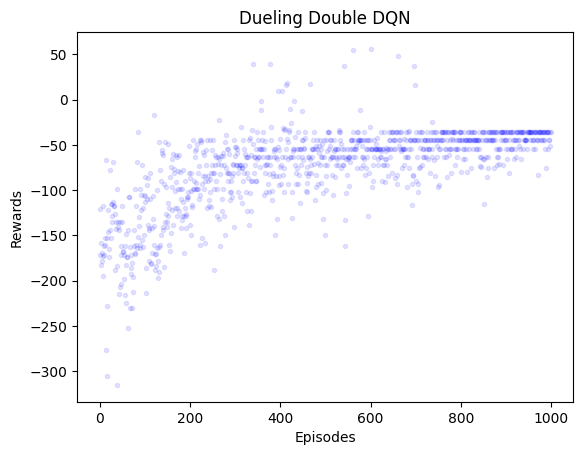

In [ ]:
  plt.plot(doubleDuelDQN_rewards, 'b.', alpha=.1)
  plt.xlabel('Episodes')
  plt.ylabel('Rewards')
  plt.title('Dueling Double DQN')

In [ ]:
len(rewards_history)

1000

Text(0, 0.5, 'Rewards Rolling Avg')

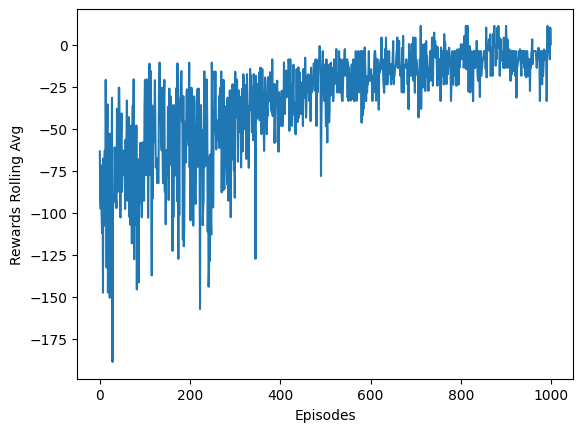

In [ ]:
plt.plot(rewards_history)
plt.xlabel('Episodes')
plt.ylabel('Rewards Rolling Avg')

# Double DQN



In [ ]:
BATCH_SIZE = 256
GAMMA = 0.5

def optimize_model_DoubleDQN():
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q values using policy net
    #print('state_batch', state_batch)
    #print('action batch', action_batch)
    Q_values = Q_network(state_batch).gather(1, action_batch)
    Q_actions = Q_network(action_batch).gather(1, action_batch)
    print('Values : ', Q_values)
    print('Actions : ', Q_actions)
    # Compute next Q values using Q_targets
    next_Q_values = Q_target(state_batch).gather(1, action_batch)

    next_Q_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0]
    
    # Compute targets
    target_Q_values = (next_Q_values * GAMMA) + reward_batch
    
    # Compute MSE Loss
    loss = F.mse_loss(Q_values, target_Q_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Trick: gradient clipping
    for param in Q_network.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()
    
    return loss